<a href="https://colab.research.google.com/github/SonalikaBisoyi/Stock_Prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub
!pip install nltk scikit-learn pandas numpy matplotlib seaborn


In [2]:
# Import Libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("aaron7sun/stocknews")
print("Dataset downloaded to:", path)


100%|██████████| 5.82M/5.82M [00:00<00:00, 87.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/aaron7sun/stocknews/versions/2


In [29]:
# Load dataset
news_data = pd.read_csv(f"{path}/Combined_News_DJIA.csv")
stock_data = pd.read_csv(f"{path}/upload_DJIA_table.csv")

# Display first few rows
print("News Data Sample:")
display(news_data.head())

print("\nStock Data Sample:")
display(stock_data.head())


News Data Sample:


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 


Stock Data Sample:


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [30]:
def preprocess_headlines(headlines):
    processed = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for line in headlines:
        line = re.sub(f'[{string.punctuation}]', '', str(line))  # Remove punctuation
        tokens = [word.lower() for word in line.split() if word.lower() not in stop_words]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        processed.append(' '.join(tokens))

    return processed

# Combine multiple headlines into one text per day
news_data['Combined'] = news_data.iloc[:, 2:27].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
news_data['Processed'] = preprocess_headlines(news_data['Combined'])


In [43]:
# Apply Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
news_data['Sentiment'] = news_data['Processed'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Merge sentiment scores with stock price data
merged_data = pd.merge(stock_data, news_data[['Date', 'Sentiment']], on='Date')

# Create target variable (1 if stock price increased, else 0)
merged_data['Price_Change'] = merged_data['Close'].diff()
merged_data['Price_Up'] = (merged_data['Price_Change'] > 0).astype(int)

# Drop NaN values
merged_data = merged_data.dropna()

# Display merged data
print("\nMerged Data Sample:")
display(merged_data.head())



Merged Data Sample:


,Date,Open,High,Low,Close,Volume,Adj Close,Sentiment,Price_Change,Price_Up
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,-0.9981,-19.378907,0
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,-0.9943,-235.310546,0
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,-0.9424,-284.958985,0
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-0.9839,-269.480469,0
5,2016-06-24,17946.630859,17946.630859,17356.339844,17400.750000,239000000,17400.750000,0.0000,260.509766,1


In [49]:
# Moving Averages (SMA & EMA)
merged_data['SMA_10'] = merged_data['Close'].rolling(window=10).mean()
merged_data['EMA_10'] = merged_data['Close'].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
merged_data['RSI_14'] = ta.momentum.RSIIndicator(merged_data['Close'], window=14).rsi()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(merged_data['Close'], window=20)
merged_data['BB_High'] = bollinger.bollinger_hband()
merged_data['BB_Low'] = bollinger.bollinger_lband()

# Drop NaN values after adding indicators
merged_data = merged_data.dropna()

# Display dataset with technical indicators
print("\nMerged Data with Technical Indicators:")
display(merged_data.head())



Merged Data with Technical Indicators:


,Date,Open,High,Low,Close,Volume,Adj Close,Sentiment,Price_Change,Price_Up,SMA_10,EMA_10,RSI_14,BB_High,BB_Low
39,2016-05-06,17650.300781,17744.539062,17580.380859,17740.630859,80020000,17740.630859,-0.9930,34.720703,1,17654.454102,17706.921629,51.054085,17986.946727,17415.050344
40,2016-05-05,17664.480469,17736.109375,17615.820312,17660.710938,81530000,17660.710938,-0.9967,-79.919921,0,17676.985156,17698.519685,47.442742,17975.863574,17411.498535
41,2016-05-04,17735.019531,17738.060547,17609.009766,17651.259766,95020000,17651.259766,-0.9981,-9.451172,0,17689.449219,17689.926972,47.019169,17958.975911,17409.656120
42,2016-05-03,17870.750000,17870.750000,17670.880859,17750.910156,97060000,17750.910156,-0.9816,99.650390,1,17711.542187,17701.014824,51.895798,17954.572997,17410.183057
43,2016-05-02,17783.779297,17912.349609,17773.710938,17891.160156,80100000,17891.160156,-0.9972,140.250000,1,17729.587109,17735.586703,57.785236,17971.305738,17403.846411


In [50]:
feature_columns = ['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low']

# Shift features to align past sentiment with future price
features = merged_data[feature_columns].shift(1).dropna()
labels = merged_data['Price_Up'].shift(-1).dropna()

# Align indexes (Ensure features and labels have same number of rows)
features = features.iloc[:-1, :]
labels = labels.iloc[:-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, shuffle=False
)

# Print feature names to ensure consistency
print("Training Features:", X_train.columns.tolist())
print("Test Features:", X_test.columns.tolist())

Training Features: ['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low']
Test Features: ['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low']


In [51]:
# --- Train Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# --- Evaluate Model ---
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)


Model Performance:
Accuracy: 0.5076923076923077

Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.18      0.27       204
         1.0       0.49      0.87      0.63       186

    accuracy                           0.51       390
   macro avg       0.55      0.52      0.45       390
weighted avg       0.55      0.51      0.44       390



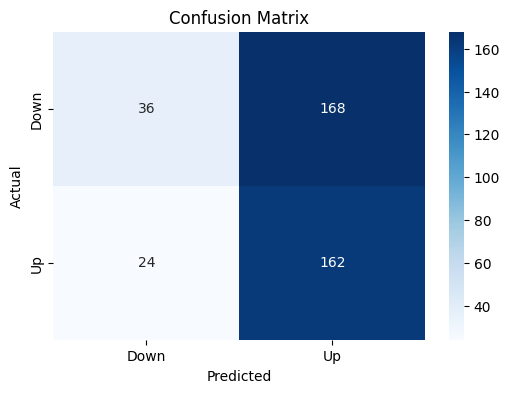

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [53]:
print("Shape of X_train:", X_train.shape)
print("Feature columns:", X_train.columns.tolist())


Shape of X_train: (1558, 6)
Feature columns: ['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low']


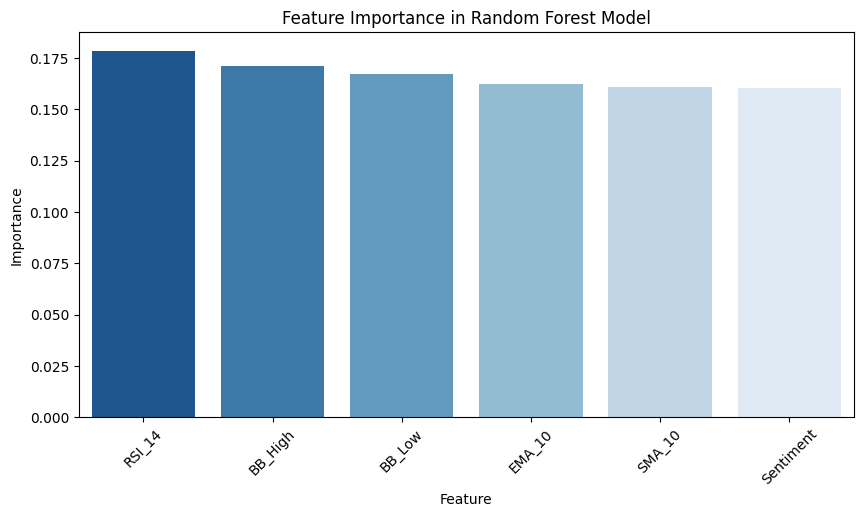

In [54]:
# --- Feature Importance Visualization ---
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance_df['Feature'], y=feature_importance_df['Importance'], palette="Blues_r")
plt.title("Feature Importance in Random Forest Model")
plt.xticks(rotation=45)
plt.show()

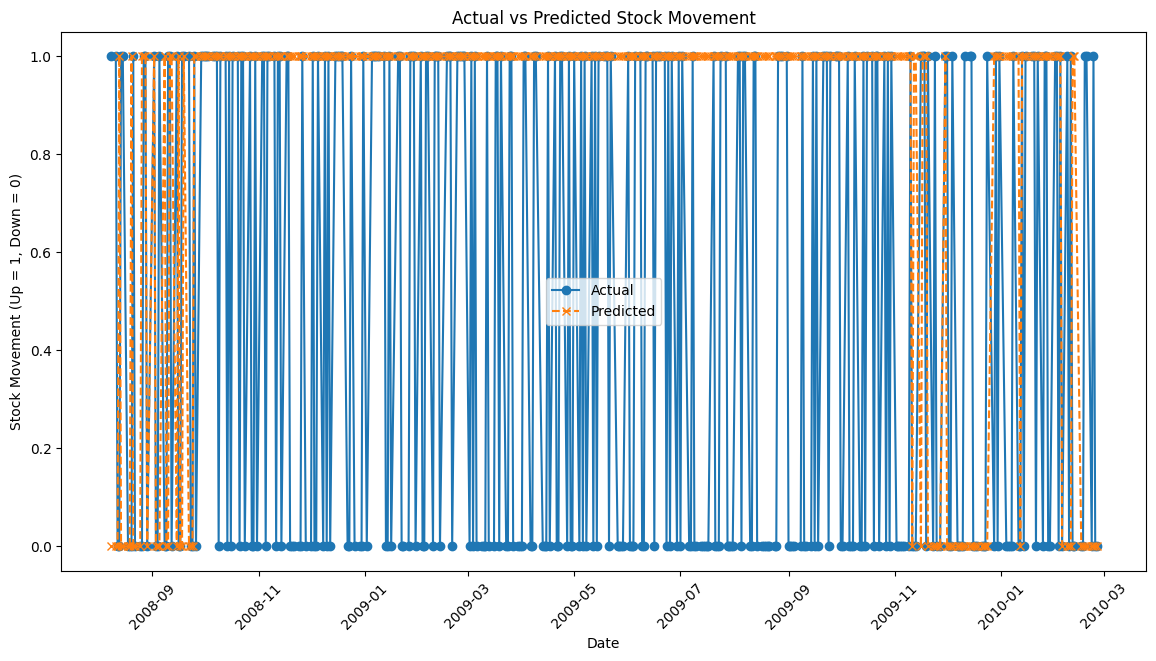

In [55]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_pred, label='Predicted', linestyle='dashed', marker='x')
plt.legend()
plt.title('Actual vs Predicted Stock Movement')
plt.xlabel('Date')
plt.ylabel('Stock Movement (Up = 1, Down = 0)')
plt.xticks(rotation=45)
plt.show()


In [12]:
!pip install  xgboost ta
import ta  # For technical indicators
import xgboost as xgb  # XGBoost Model

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5c90b99f540c2d9b7b91c917a3a81a1013407a2a26a1befa70e907c7436c3d86
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [13]:
# Moving Averages (SMA & EMA)
merged_data['SMA_10'] = merged_data['Close'].rolling(window=10).mean()  # 10-day Simple Moving Average
merged_data['EMA_10'] = merged_data['Close'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average

# Relative Strength Index (RSI)
merged_data['RSI_14'] = ta.momentum.RSIIndicator(merged_data['Close'], window=14).rsi()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(merged_data['Close'], window=20)
merged_data['BB_High'] = bollinger.bollinger_hband()
merged_data['BB_Low'] = bollinger.bollinger_lband()

# Drop NaN values after adding indicators
merged_data = merged_data.dropna()

# Display dataset with technical indicators
print("\nMerged Data with Technical Indicators:")
display(merged_data.head())



Merged Data with Technical Indicators:


,Date,Open,High,Low,Close,Volume,Adj Close,Sentiment,Price_Change,Price_Up,SMA_10,EMA_10,RSI_14,BB_High,BB_Low
20,2016-06-03,17799.800781,17833.169922,17689.679688,17807.060547,82270000,17807.060547,-0.9538,-113.269531,0,17830.182031,17849.960629,49.244474,18184.552196,17313.333936
21,2016-06-02,17789.050781,17838.560547,17703.550781,17838.560547,75560000,17838.560547,-0.9975,31.500000,1,17840.728125,17847.887887,50.605820,18174.164978,17314.578186
22,2016-06-01,17754.550781,17809.179688,17664.789062,17789.669922,78530000,17789.669922,-0.9975,-48.890625,0,17855.678125,17837.302803,48.434424,18178.712368,17319.529819
23,2016-05-31,17891.500000,17899.240234,17724.029297,17787.199219,147390000,17787.199219,-0.9894,-2.470703,0,17866.916016,17828.193060,48.321585,18168.463778,17367.526261
24,2016-05-27,17826.849609,17873.220703,17824.730469,17873.220703,73190000,17873.220703,-0.9970,86.021484,1,17880.990039,17836.379904,52.473180,18084.647431,17524.640654


In [14]:
# Moving Averages (SMA & EMA)
merged_data['SMA_10'] = merged_data['Close'].rolling(window=10).mean()  # 10-day Simple Moving Average
merged_data['EMA_10'] = merged_data['Close'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average

# Relative Strength Index (RSI)
merged_data['RSI_14'] = ta.momentum.RSIIndicator(merged_data['Close'], window=14).rsi()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(merged_data['Close'], window=20)
merged_data['BB_High'] = bollinger.bollinger_hband()
merged_data['BB_Low'] = bollinger.bollinger_lband()

# Drop NaN values after adding indicators
merged_data = merged_data.dropna()

# Display dataset with technical indicators
print("\nMerged Data with Technical Indicators:")
display(merged_data.head())



Merged Data with Technical Indicators:


,Date,Open,High,Low,Close,Volume,Adj Close,Sentiment,Price_Change,Price_Up,SMA_10,EMA_10,RSI_14,BB_High,BB_Low
39,2016-05-06,17650.300781,17744.539062,17580.380859,17740.630859,80020000,17740.630859,-0.9930,34.720703,1,17654.454102,17706.921629,51.054085,17986.946727,17415.050344
40,2016-05-05,17664.480469,17736.109375,17615.820312,17660.710938,81530000,17660.710938,-0.9967,-79.919921,0,17676.985156,17698.519685,47.442742,17975.863574,17411.498535
41,2016-05-04,17735.019531,17738.060547,17609.009766,17651.259766,95020000,17651.259766,-0.9981,-9.451172,0,17689.449219,17689.926972,47.019169,17958.975911,17409.656120
42,2016-05-03,17870.750000,17870.750000,17670.880859,17750.910156,97060000,17750.910156,-0.9816,99.650390,1,17711.542187,17701.014824,51.895798,17954.572997,17410.183057
43,2016-05-02,17783.779297,17912.349609,17773.710938,17891.160156,80100000,17891.160156,-0.9972,140.250000,1,17729.587109,17735.586703,57.785236,17971.305738,17403.846411


In [15]:
# Create feature set (Shift sentiment to match previous day's sentiment with next day's price)
features = merged_data[['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low']].shift(1).dropna()
labels = merged_data['Price_Up'].shift(-1).dropna()

# Align indexes
features = features.iloc[:-1, :]
labels = labels.iloc[:-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)


In [16]:
# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate Model
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Model Performance:
Accuracy: 0.5153846153846153

Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.32      0.41       204
         1.0       0.49      0.73      0.59       186

    accuracy                           0.52       390
   macro avg       0.53      0.52      0.50       390
weighted avg       0.53      0.52      0.50       390


Confusion Matrix:
 [[ 66 138]
 [ 51 135]]


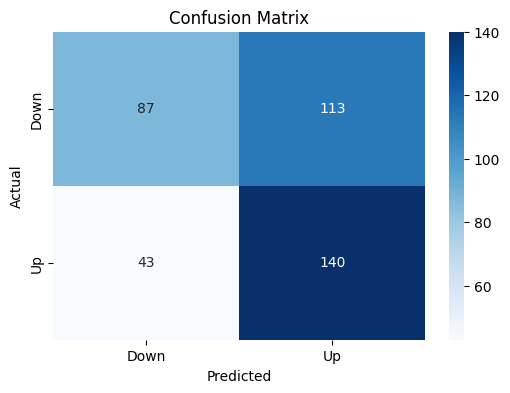

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


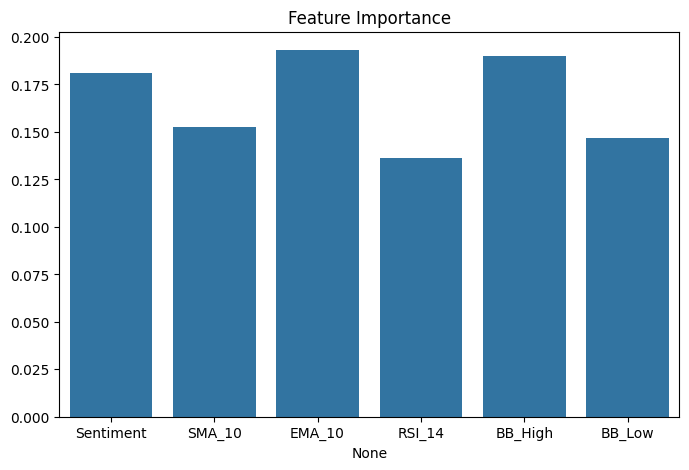

In [17]:
# Plot Feature Importance
importance = xgb_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=features.columns, y=importance)
plt.title('Feature Importance')
plt.show()


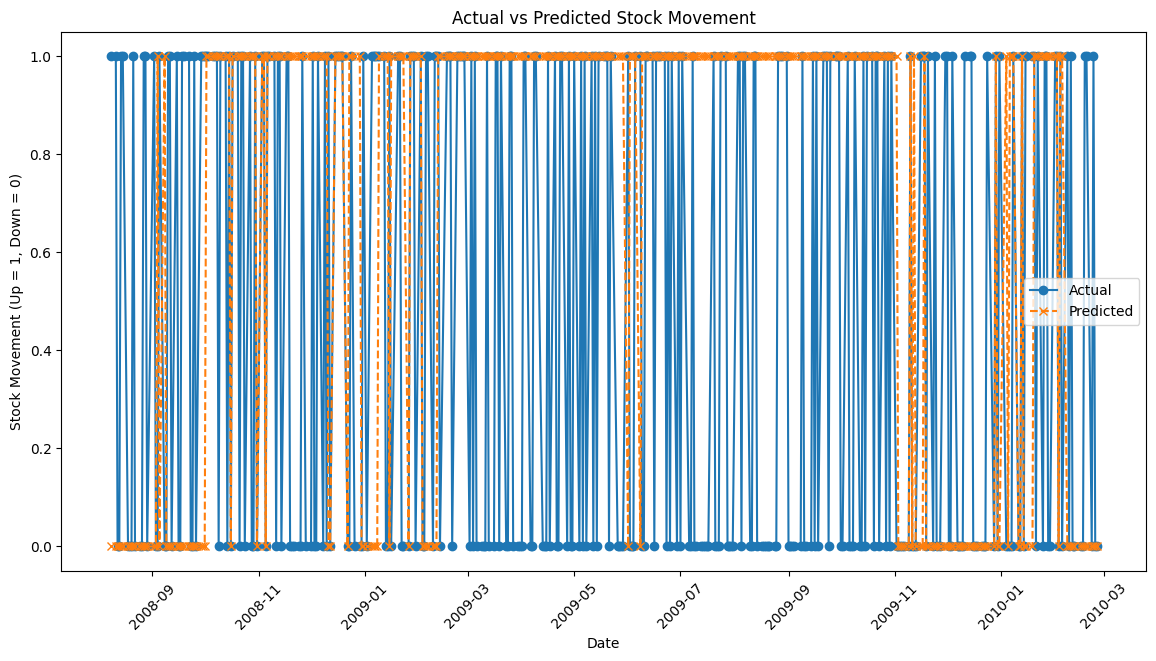

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_pred, label='Predicted', linestyle='dashed', marker='x')
plt.legend()
plt.title('Actual vs Predicted Stock Movement')
plt.xlabel('Date')
plt.ylabel('Stock Movement (Up = 1, Down = 0)')
plt.xticks(rotation=45)
plt.show()


In [19]:
!pip install optuna
import optuna  # For hyperparameter tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.1 MB/s eta 0:00:00


In [20]:
# Moving Averages (SMA & EMA)
merged_data['SMA_10'] = merged_data['Close'].rolling(window=10).mean()
merged_data['EMA_10'] = merged_data['Close'].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
merged_data['RSI_14'] = ta.momentum.RSIIndicator(merged_data['Close'], window=14).rsi()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(merged_data['Close'], window=20)
merged_data['BB_High'] = bollinger.bollinger_hband()
merged_data['BB_Low'] = bollinger.bollinger_lband()

# MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(merged_data['Close'])
merged_data['MACD'] = macd.macd()
merged_data['MACD_Signal'] = macd.macd_signal()

# ADX (Average Directional Index)
merged_data['ADX'] = ta.trend.ADXIndicator(merged_data['High'], merged_data['Low'], merged_data['Close'], window=14).adx()

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(merged_data['High'], merged_data['Low'], merged_data['Close'], window=14)
merged_data['Stoch_K'] = stoch.stoch()
merged_data['Stoch_D'] = stoch.stoch_signal()

# Drop NaN values after adding indicators
merged_data = merged_data.dropna()


In [21]:
# Create feature set (Shift sentiment to match previous day's sentiment with next day's price)
features = merged_data[['Sentiment', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_High', 'BB_Low', 'MACD', 'MACD_Signal', 'ADX', 'Stoch_K', 'Stoch_D']].shift(1).dropna()
labels = merged_data['Price_Up'].shift(-1).dropna()

# Align indexes
features = features.iloc[:-1, :]
labels = labels.iloc[:-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)


In [22]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train final model with best params
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


[I 2025-03-22 15:37:15,673] A new study created in memory with name: no-name-9cdf3e1a-c108-4c0f-93c5-78b9d219e4b0
[I 2025-03-22 15:37:16,439] Trial 0 finished with value: 0.556135770234987 and parameters: {'n_estimators': 127, 'max_depth': 9, 'learning_rate': 0.044758023408709796, 'subsample': 0.7793153247344313, 'colsample_bytree': 0.5749136874669136}. Best is trial 0 with value: 0.556135770234987.
[I 2025-03-22 15:37:17,095] Trial 1 finished with value: 0.5613577023498695 and parameters: {'n_estimators': 109, 'max_depth': 4, 'learning_rate': 0.27113214958076975, 'subsample': 0.8497652668745137, 'colsample_bytree': 0.528706751532763}. Best is trial 1 with value: 0.5613577023498695.
[I 2025-03-22 15:37:18,115] Trial 2 finished with value: 0.556135770234987 and parameters: {'n_estimators': 255, 'max_depth': 5, 'learning_rate': 0.024721659665131165, 'subsample': 0.702480573113301, 'colsample_bytree': 0.6833137289840098}. Best is trial 1 with value: 0.5613577023498695.
[I 2025-03-22 15:37

Best Hyperparameters: {'n_estimators': 110, 'max_depth': 10, 'learning_rate': 0.016445818912199362, 'subsample': 0.536938142539976, 'colsample_bytree': 0.8357368655971366}


In [23]:
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Model Performance:
Accuracy: 0.5926892950391645

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.43      0.53       200
         1.0       0.55      0.77      0.64       183

    accuracy                           0.59       383
   macro avg       0.61      0.60      0.58       383
weighted avg       0.61      0.59      0.58       383


Confusion Matrix:
 [[ 87 113]
 [ 43 140]]


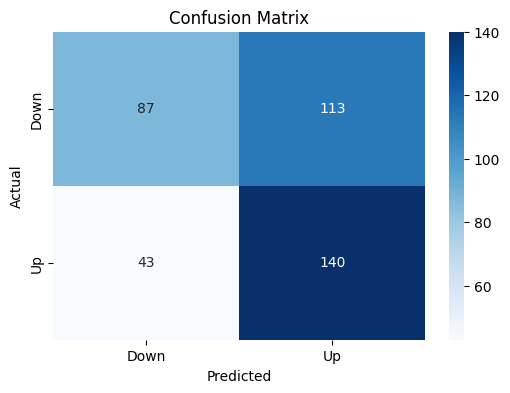

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


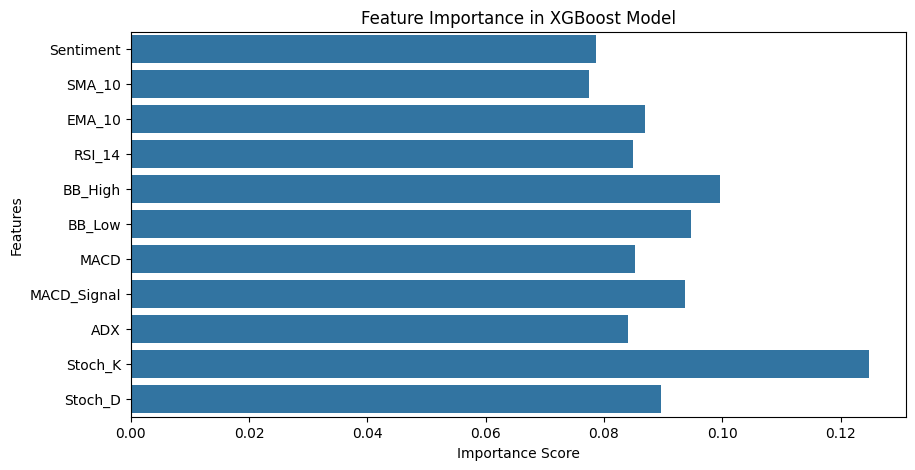

In [25]:
# Plot Feature Importance
importance = xgb_model.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=importance, y=features.columns)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()


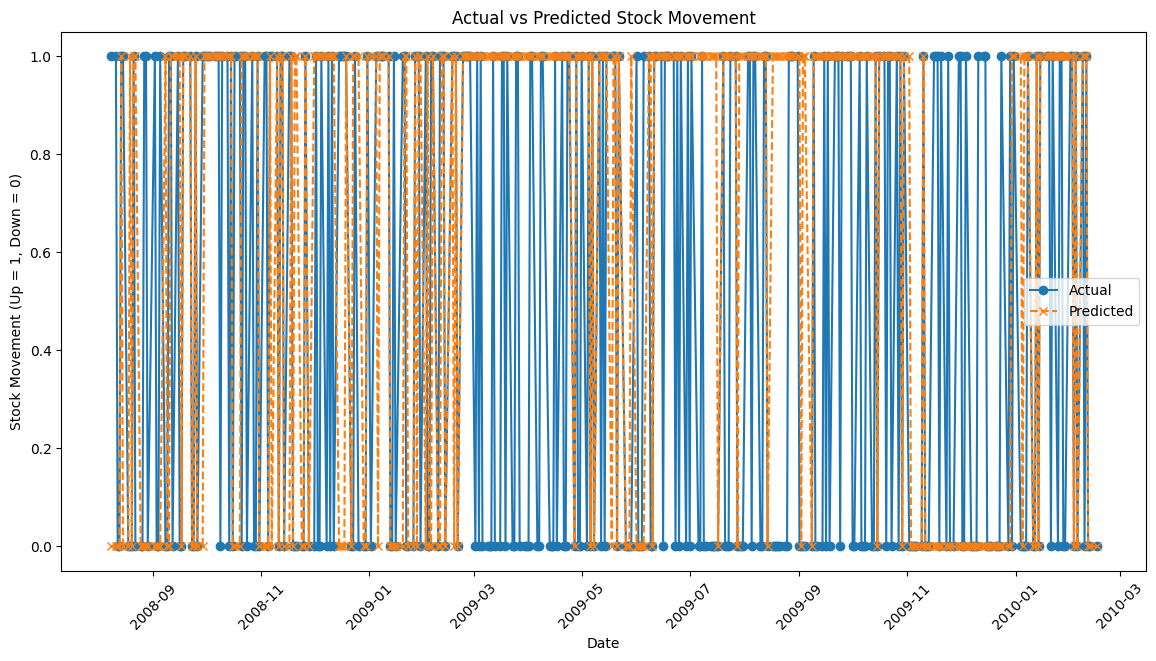

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(merged_data['Date'].iloc[-len(y_test):], y_pred, label='Predicted', linestyle='dashed', marker='x')
plt.legend()
plt.title('Actual vs Predicted Stock Movement')
plt.xlabel('Date')
plt.ylabel('Stock Movement (Up = 1, Down = 0)')
plt.xticks(rotation=45)
plt.show()
